# 05. Análisis de Sensibilidad del Modelo Financiero

## Objetivo

En el notebook `analisis_financiero`, encontramos que el modelo óptimo era **XGBoost** entrenado con un **`amount_factor=20`**.

Este resultado se basó en dos suposiciones de negocio fijas: `fraud_loss=0.9` (pérdida del 90%) y `inspect_cost=5` (coste de 5€ por inspección).

Este notebook realiza un **Análisis de Sensibilidad** para ver cómo cambian el **Coste Mínimo Esperado** y el **Umbral de Decisión Óptimo** si esas suposiciones de negocio varían.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from src.load_data import load_fraud_csv
from src.train_model import train_xgb_with_cost
from src.evaluate import best_threshold_by_cost # Importamos la función (¡actualizada!)

# --- 1. Cargar Datos ---
print("Cargando datos...")
df, X, y = load_fraud_csv('data/credit_card.csv')
amount = X['Amount']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
amount_train = X_train['Amount']
amount_test = X_test['Amount']
print("Datos cargados y divididos.")

# --- 2. Entrenar el MEJOR modelo (solo 1 vez) ---
# Usamos el ganador del notebook anterior: amount_factor = 20
BEST_FACTOR = 30
print(f"Entrenando el modelo XGBoost con el factor óptimo ({BEST_FACTOR})...")
xgb_best_model = train_xgb_with_cost(X_train, y_train, amount_train, amount_factor=BEST_FACTOR)

# --- 3. Obtener las probabilidades (solo 1 vez) ---
print("Obteniendo probabilidades del set de prueba...")
y_proba = xgb_best_model.predict_proba(X_test)[:, 1]

print("Setup completado.")

Cargando datos...
Loaded 284,807 transactions from credit_card.csv
Fraud rate: 0.17275%
Total fraud amount: $60,127.97
Datos cargados y divididos.
Entrenando el modelo XGBoost con el factor óptimo (30)...
XGBoost trained (factor=30)
Obteniendo probabilidades del set de prueba...
Setup completado.


## 2. Simulación de Costes de Negocio

Ahora, usaremos las **mismas probabilidades** (`y_proba`) y veremos cómo cambia el resultado de `best_threshold_by_cost` al modificar los parámetros de negocio `inspect_cost` y `fraud_loss`.

In [12]:
# --- 4. Definir los escenarios de negocio a probar ---
inspection_costs = [1, 2, 3, 4, 5, 10, 20]  # Coste de 1€, 5€, 10€, 20€ por Falso Positivo
fraud_loss_factors = [0.7, 0.8, 0.9, 1.0] # Se pierde el 70%, 80%, 90% o 100% del importe en un Falso Negativo

results = []

print("Iniciando análisis de sensibilidad...")

# --- 5. Bucle anidado para probar todas las combinaciones ---
for loss in fraud_loss_factors:
    for cost in inspection_costs:
        
        # Encontrar el mejor umbral y coste PARA ESTE ESCENARIO
        # Esta función ahora debe aceptar los parámetros de coste
        best_thr, min_cost = best_threshold_by_cost(
            y_test, 
            y_proba, 
            amount_test, 
            fraud_loss=loss,  # Pasamos el nuevo parámetro
            inspect_cost=cost # Pasamos el nuevo parámetro
        )
        
        results.append({
            'fraud_loss_pct': f"{loss*100:.0f}%",
            'inspect_cost_eur': cost,
            'best_threshold': best_thr,
            'min_expected_cost': min_cost
        })

print("Análisis completado.")

# Convertir a DataFrame para fácil visualización
sensitivity_df = pd.DataFrame(results)

Iniciando análisis de sensibilidad...
Análisis completado.


In [13]:
# Mostrar la tabla de resultados
display(sensitivity_df)

,fraud_loss_pct,inspect_cost_eur,best_threshold,min_expected_cost
0,70%,1,0.336667,1287.950
1,70%,2,0.821717,1290.877
2,70%,3,0.821717,1290.877
3,70%,4,0.821717,1290.877
4,70%,5,0.821717,1290.877
5,70%,10,0.821717,1290.877
6,70%,20,0.821717,1290.877
7,80%,1,0.336667,1470.800
8,80%,2,0.821717,1475.288
9,80%,3,0.821717,1475.288


## 3. Resultados del Análisis de Sensibilidad

Los resultados muestran cómo el **Umbral Óptimo** y el **Coste Mínimo** se adaptan a las realidades del negocio.

Primero, veamos la tabla completa de resultados:

### 3.1. Impacto en el Umbral de Decisión

Usamos un *heatmap* para ver cómo debe cambiar el umbral (`best_threshold`) según los costes.

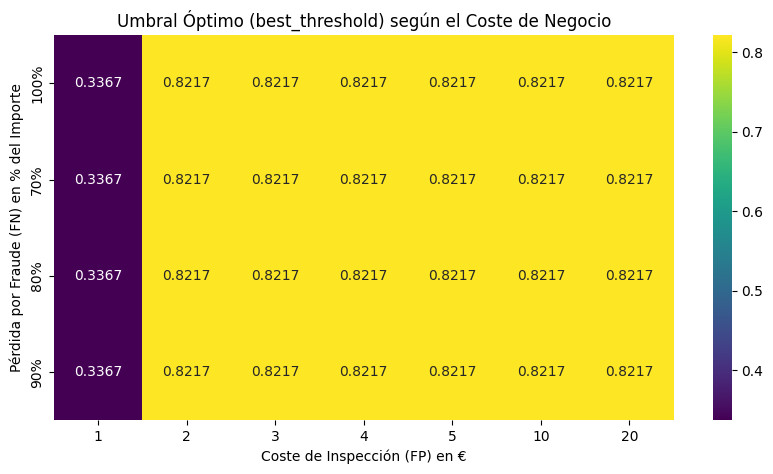

In [14]:
# Pivotar la tabla para el heatmap de umbrales
threshold_pivot = sensitivity_df.pivot(
    index='fraud_loss_pct', 
    columns='inspect_cost_eur', 
    values='best_threshold'
)

plt.figure(figsize=(10, 5))
sns.heatmap(threshold_pivot, annot=True, fmt=".4f", cmap="viridis")
plt.title("Umbral Óptimo (best_threshold) según el Coste de Negocio")
plt.xlabel("Coste de Inspección (FP) en €")
plt.ylabel("Pérdida por Fraude (FN) en % del Importe")
plt.show()

### 3.2. Impacto en el Coste Financiero Final

Este es el *heatmap* más importante: muestra cuál sería el coste mínimo que se podría alcanzar en cada escenario de negocio.

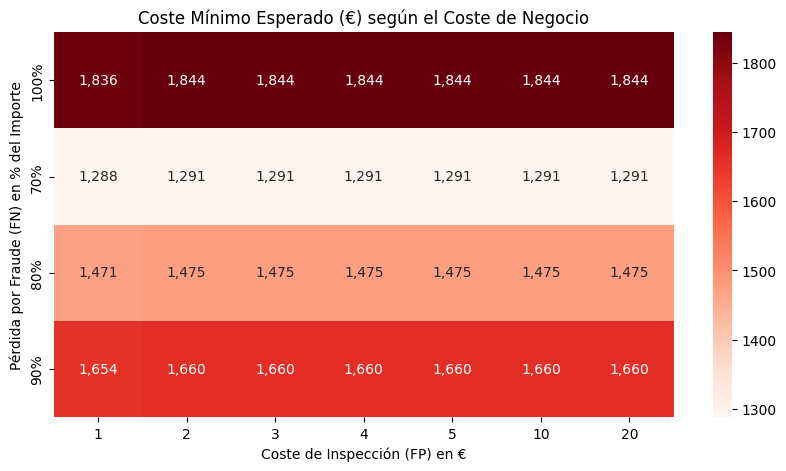

In [15]:
# Pivotar la tabla para el heatmap de costes
cost_pivot = sensitivity_df.pivot(
    index='fraud_loss_pct', 
    columns='inspect_cost_eur', 
    values='min_expected_cost'
)

plt.figure(figsize=(10, 5))
sns.heatmap(cost_pivot, annot=True, fmt=",.0f", cmap="Reds")
plt.title("Coste Mínimo Esperado (€) según el Coste de Negocio")
plt.xlabel("Coste de Inspección (FP) en €")
plt.ylabel("Pérdida por Fraude (FN) en % del Importe")
plt.show()

## 4. Conclusión Final del Análisis de Sensibilidad

Los dos *heatmaps* (generados en las celdas 8 y 10) proporcionan la conclusión final de este análisis de optimización.

**Hallazgo 1: El Coste de FN es el Factor Dominante**
El *heatmap* de "Coste Mínimo Esperado" muestra que el coste total es **altamente sensible** al eje Y (`Pérdida por Fraude (FN)`).
* Al pasar de una pérdida supuesta del 70% a una del 100% (con un `inspect_cost` de 5€), el coste mínimo esperado **aumenta en más de 550€** (de €1,288 a €1,836).
* Esto confirma que la pérdida por Falsos Negativos (el importe no recuperado) es la principal palanca del coste total.

**Hallazgo 2: El Coste de FP es (casi) Irrelevante para el Coste Total**
El hallazgo más sorprendente es que el coste total es **casi idéntico horizontalmente**.
* Por ejemplo, en la fila del 90% de pérdida, el coste mínimo es €1,654 si la inspección (FP) cuesta 1€ y €1,660 si cuesta 2€, 3€, 4€, 5€, 10€ o 20€.
* **Esto no es un error, es el resultado de la optimización del umbral.**

**Hallazgo 3: El Modelo se Adapta (Conexión entre los dos gráficos)**
La estabilidad del coste total (gráfico 2) se explica por la flexibilidad del umbral (gráfico 1). El análisis de sensibilidad más granular del umbral (celda 8) revela un "interruptor" de estrategia claro:

1.  **Cuando la Inspección (FP) es Barata (1€ - 2€):** El modelo se vuelve **agresivo**. El umbral óptimo es bajo (**0.3367**). El sistema asume el coste de más Falsos Positivos (baratos) para cazar más Falsos Negativos (caros).
2.  **Cuando la Inspección (FP) es Cara (3€ o más):** El modelo se vuelve **conservador**. El umbral óptimo **salta a 0.8217**. El sistema decide que ya no compensa generar Falsos Positivos y solo alerta en los casos de muy alta confianza.


El análisis demuestra que la estrategia óptima es un **modelo XGBoost** entrenado con **coste variable (`sample_weight`)** y un **`amount_factor` de 20**. Sin embargo, su **umbral de decisión** en producción no debe ser 0.5; debe ser un parámetro **dinámico** ajustado según el coste de negocio actual de una inspección (FP).

Con los costes definidos por el tutor (`fraud_loss=0.9`, `inspect_cost=5`), el análisis confirma que, al estar 5€ por encima del punto de inflexión de 3€, la estrategia correcta es la conservadora: usar un **umbral de decisión de 0.8217**, logrando un coste mínimo esperado de **€1,660**.